I talked to Gaurav on July 11 after class and we thought of 2 architectures. In both cases, we will use transfer learning from something like BERT. In both cases, we want to get embeddings for:
* the overview AND
* some main features (like genres, production companies | director and actors may be harder to get an embedding for).
Then, we will concat the two separate embeddings and use them for clustering. It would probably be better (and more natural) to train both halves together so the embeddings fit together.

1. Multi-task learning.
2. Have the genres or the production companies as "style". This will push the embeddings to form clusters.
3. Train the overview separately (maybe for auto-encoder) and the features (maybe for classification) separately then concat them together.

In all cases, the network must be trained to reach a goal, then the embeddings it came up with in the middle will be used for clsutering and interpolation.

> Since I will be doing transfer learning, it is better to have a warmup_rate so I do not shock the weights. So, I start with a smaller learning rate then work up to the learning rate I want.

[Fine tuning BERT for multi-label classfication](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=4wxY3x-ZZz8h)

[Getting word and sentence embeddings from BERT](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)

In [51]:
import torch
DEV_MODE = True
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [52]:
from data_prep import load_movies_full_df

MIN_VOTES_PER_MOVIE = 50
NEUTRAL_RATING = 2.5
MIN_POSITIVE_VOTES_PER_USER = 20
DESIRED_COLUMNS = ['id', 'cast', 'title', 'crew',
                   'genres', 'overview', 'production_companies']

df = load_movies_full_df(
        movies_metadata_path='data/IMDB_Ratings/movies_metadata.csv',
        credits_path='data/IMDB_Ratings/credits.csv',
        n_votes=MIN_VOTES_PER_MOVIE,
        desired_columns=DESIRED_COLUMNS)

c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_metadata_path)
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enough_votes['overview'] = enough_votes['overview'].fillna('')


In [53]:
df.head()

,id,cast,title,crew,genres,overview,production_companies
0,862,"[{'cast_id': 14, 'character': 'Woody (voice)',...",Toy Story,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...","[{'name': 'Pixar Animation Studios', 'id': 3}]"
1,8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '...",Jumanji,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na..."
2,15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...",Grumpier Old Men,"[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'..."
3,11862,"[{'cast_id': 1, 'character': 'George Banks', '...",Father of the Bride Part II,"[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,"[{'name': 'Sandollar Productions', 'id': 5842}..."
4,949,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...",Heat,"[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","Obsessive master thief, Neil McCauley leads a ...","[{'name': 'Regency Enterprises', 'id': 508}, {..."


In [4]:
if DEV_MODE:
    df = df.head(100)

## Prepare for classification

We will use the genres of the movies (and maybe the production companies later) as the labels of the movie. This will result in this becoming a multi-label problem, since most movies fall under more than one genre.

> A question to answer is whether we should only keep it as the top 3 genres, or have all genres.

In [ ]:
from data_prep import get_distil_data

df = get_distil_data('distil_data.csv')

In [54]:
from features import get_top_n_per_feature, parse_into_python_objects

# the csv files have stringified objects to represnt the cast, the crew, the genres and the prodiction companies
# we have to parse them into python objects
df = parse_into_python_objects(df, ['cast', 'crew', 'genres', 'production_companies'])

# let's extract the top 3 genres and the top 2 production companies of a movie into lists (instead of objects)
df = get_top_n_per_feature(df, [('genres', 3)])

Parsing stringified objects into Python readable objects ...
Extracting top 3 genres ...


In [58]:
df[['id', 'overview', 'genres']].to_csv('distil_data.csv')

In [6]:
df['genres'].tail(20)

80       [Action, Crime, Fantasy]
81               [Drama, Romance]
82               [Action, Comedy]
83      [Fantasy, Comedy, Family]
84        [Mystery, Crime, Drama]
85     [Action, Adventure, Drama]
86      [Action, Thriller, Drama]
87                  [Documentary]
88      [Thriller, Action, Crime]
89     [Drama, Mystery, Thriller]
90             [Action, Thriller]
91        [Action, Comedy, Crime]
92     [Action, Adventure, Drama]
93                    [Adventure]
94      [Action, Crime, Thriller]
95     [Adventure, Action, Drama]
96              [Science Fiction]
97                 [Drama, Crime]
98                [Drama, Comedy]
99    [Mystery, Horror, Thriller]
Name: genres, dtype: object

### Turn genres into one-hot-encoded columns

To classify the movies over genres, we have to turn them into one-hot encoded columns, where each column represents a genre, and it's value is 1 if the movie falls under this genre and 0 otherwise.

In [7]:
# one hot encoding the genres
# note: it is better for memory to use a sparse matrix, but it is not compatible with the tokenizer
# solution taken from: https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

mlb_genres = MultiLabelBinarizer()

df = df.join(
        pd.DataFrame(
            mlb_genres.fit_transform(df.pop('genres')),
            columns=mlb_genres.classes_,
            index=df.index
        )
)

In [8]:
genre_names = mlb_genres.classes_.tolist()
genre_names

['Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War']

### Add Production Companies
Now that we added the genres. We can also try to add the production companies. We can add the top 2 production companies.

In [10]:
mlb_prod_companies = MultiLabelBinarizer()

df = df.join(
        pd.DataFrame(
            mlb_prod_companies.fit_transform(df.pop('production_companies')),
            columns=mlb_prod_companies.classes_,
            index=df.index
        )
)

KeyError: 'genres'

In [ ]:
prod_company_names = mlb_prod_companies.classes_.tolist()

### Create label indices
To ease our training, we will map our labels from strings to integers. Later on, we might want to map them back to their string format for interpretability. 

We will keep this flexible to accomodate for the genres only, the production companies only, or both.

> Idea: can I do multi-task learning where I use the same input to train two-classifiers: one for the genres and one for the production companies?

In [9]:
labels = genre_names # + prod_company_names
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

### Train/Test Split

We will split the dataset into training-testing (80%-20%) to help with the training.

In [10]:
from datasets import Dataset, DatasetDict
import numpy as np

# create a mask to split data into training and testing
msk = np.random.rand(len(df)) < 0.8

# TODO should I drop all the columns that I do not need (i.e., cast, crew, maybe title)
dataset = DatasetDict(
    train = Dataset.from_pandas(df[msk]),
    test = Dataset.from_pandas(df[~msk])
)

### Find the max length of tokens

The tokenizer will turn the words in a sentence into IDs. Since BERT is a neural network, it takes a fixed size input (i.e., fixed number of tokens) everytime. Nonetheless, not all ovewrviews have the same length. 

To overcome this problem, we give ourt tokenizer a `max_length` that all inputs should have. 
- If the overview has less words than `max_length`, we add `[PAD]` tokens to it till it reaches this `max_length`. 
- If the overview has more words than `max_length`, we turncate it to only have as many words as `max_length`.

To find a good `max_length` we will run simple statistics on the overview column of our dataset and we will use the 95th percentile of token length as our tokens' `max_length`.

In [11]:
count = df['overview'].str.split().str.len()
count.describe()

count    100.000000
mean      51.180000
std       23.965202
min        7.000000
25%       31.500000
50%       52.000000
75%       67.250000
max      123.000000
Name: overview, dtype: float64

In [12]:
tokens_max_length = count.quantile(0.95)

### Encoding/tokenizing the overview

The tokenizer will turn the words in a sentence into IDs, which correspond to the IDs that the original BERT used to represent words when it was training. This is crucial for the transfer-learning to work, to ensure consistency between the representations of the words that we will use.

Moreover, we will need the labels of each class to be used as the output of the model.


In [21]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["overview"]
  # encode them
  encoding = tokenizer(
    text, 
    padding="max_length", 
    truncation=True, 
    max_length=int(tokens_max_length), 
    # return_tensors='pt'
  ) # .to(device)
  
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  encoding["id"] = examples["id"]
  
  return encoding

In [22]:
encoded_dataset = dataset.map(
    preprocess_data, 
    batched=True, # default batch size is 1,000
    # the returned values will have a new shape, 
    # so we must drop the old columns lest we have shape mismatch problems
    remove_columns=dataset['train'].column_names 
)

100%|██████████| 1/1 [00:00<00:00, 27.71ba/s]


In [23]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [25]:
tokenizer.decode(example['input_ids'])

"[CLS] when siblings judy and peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite alan - - an adult who's been trapped inside the game for 26 years - - into their living room. alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. [SEP] [PAD] [PAD]"

In [26]:
example['labels']

[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [27]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['Adventure', 'Family', 'Fantasy']

In [28]:
# set the format of our data to PyTorch tensors. 
# This will turn the training, validation and test sets into standard PyTorch datasets
encoded_dataset.set_format("torch")

# Define Model
We will use a pre-trained BERT model and do transfer-learning to classify the overviews into genres. This means that we have a multi-label classification problem, and we will have to modify the BERT pretrained model that we are given as it only supports binary classificatoin by default.

It is important to note that we primairly do this classification to encode some movie specific data into the embeddings of words/sentence of the overview. The final goal is to take these embeddings and use their domain to run nearest-neighbor or interpolation to find movie recommendations.

Here we define a model that includes a pre-trained base (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

This is also printed by the warning.

We set the `problem_type` to be "multi_label_classification", as this will make sure the appropriate loss function is used (namely [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)). We also make sure the output layer has `len(labels)` output neurons, and we set the id2label and label2id mappings.

In [29]:
from transformers import AutoModelForSequenceClassification

# TODO we should tell the model that we will want to extract the embeddings
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id,
                                                           output_hidden_states=True)

# no need to send the model explicitly to the GPU, the trainer will do that for me
# model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## Train the model
We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

- `TrainingArguments`, which specify training hyperparameters. All options can be found in the docs. Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
- a `Trainer` object (docs can be found here).

In [30]:
batch_size = 32
metric_name = "f1" # TODO should I use accuracy?

In [31]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [33]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [34]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  2043,  9504, 12120,  1998,  2848,  7523,  2019, 22454,  2604,
         2208,  2008,  7480,  1996,  2341,  2000,  1037,  8687,  2088,  1010,
         2027,  4895,  9148, 13027,  2135, 13260,  5070,  1011,  1011,  2019,
         4639,  2040,  1005,  1055,  2042,  7567,  2503,  1996,  2208,  2005,
         2656,  2086,  1011,  1011,  2046,  2037,  2542,  2282,  1012,  5070,
         1005,  1055,  2069,  3246,  2005,  4071,  2003,  2000,  3926,  1996,
         2208,  1010,  2029, 16481, 19188,  2004,  2035,  2093,  2424,  3209,
         2770,  2013,  5016, 24091, 17119, 27465,  1010,  4763, 17059,  1998,
         2060, 17082,  7329,  1012,   102,     0,     0])

In [35]:
#forward pass
outputs = model(
    input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), 
    labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7722, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.8062,  0.0043,  0.5874,  0.3624,  0.0475,  0.1799,  0.5663,  0.5486,
         -0.2649, -0.5155, -0.3317, -0.3034,  0.5412, -0.2086, -0.0707,  0.0891,
          0.5054]], grad_fn=<AddmmBackward0>), hidden_states=(tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.4807,  0.8188, -0.4227,  ..., -0.1415,  1.1064,  0.5430],
         [ 0.1751, -0.3431, -1.0606,  ..., -0.1269,  0.5795, -0.2664],
         ...,
         [-0.4976,  0.1075,  0.3954,  ..., -0.6796,  0.0103, -0.0790],
         [ 0.1598, -0.3782,  0.1954,  ..., -0.1481, -0.5739,  0.1019],
         [-0.0436, -0.5786,  0.5365,  ..., -0.2000, -0.4886, -0.0453]]],
       grad_fn=<NativeLayerNormBackward0>), tensor([[[ 0.0608, -0.0230, -0.2425,  ...,  0.2075, -0.0869, -0.0231],
         [-1.3177,  0.7007, -0.4374,  ..., -0.2224,  0.9212,  0.7522],
         [ 0.0589, -0.4386, -0.5371,  ..., -0.

Let's start training..

In [36]:
trainer = Trainer(
    model,
    args,
    # TODO are these datasets on GPU or CPU?
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [37]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id. If id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641-env\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 81
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 15
 20%|██        | 3/15 [00:48<03:03, 15.28s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequ

{'eval_loss': 0.6802330613136292, 'eval_f1': 0.18072289156626506, 'eval_roc_auc': 0.48156146179402, 'eval_accuracy': 0.0, 'eval_runtime': 4.2324, 'eval_samples_per_second': 4.489, 'eval_steps_per_second': 0.236, 'epoch': 1.0}


Model weights saved in bert-finetuned-sem_eval-english\checkpoint-3\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-3\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-3\special_tokens_map.json
 40%|████      | 6/15 [01:49<02:38, 17.58s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id. If id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 19
  Batch size = 32
                                              
 40%|████      | 6/15 [01:54<02:38, 17.58s/it]Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-6
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-6\config.json


{'eval_loss': 0.6383912563323975, 'eval_f1': 0.17460317460317462, 'eval_roc_auc': 0.4993355481727575, 'eval_accuracy': 0.0, 'eval_runtime': 4.7501, 'eval_samples_per_second': 4.0, 'eval_steps_per_second': 0.211, 'epoch': 2.0}


Model weights saved in bert-finetuned-sem_eval-english\checkpoint-6\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-6\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-6\special_tokens_map.json
 60%|██████    | 9/15 [03:04<02:03, 20.61s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id. If id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 19
  Batch size = 32
                                              
 60%|██████    | 9/15 [03:08<02:03, 20.61s/it]Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-9
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-9\config.json


{'eval_loss': 0.6200209856033325, 'eval_f1': 0.17857142857142858, 'eval_roc_auc': 0.510921926910299, 'eval_accuracy': 0.0, 'eval_runtime': 4.1768, 'eval_samples_per_second': 4.549, 'eval_steps_per_second': 0.239, 'epoch': 3.0}


Model weights saved in bert-finetuned-sem_eval-english\checkpoint-9\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-9\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-9\special_tokens_map.json
 80%|████████  | 12/15 [04:00<00:54, 18.23s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id. If id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 19
  Batch size = 32
                                               
 80%|████████  | 12/15 [04:04<00:54, 18.23s/it]Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-12
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-12\config.json


{'eval_loss': 0.6076399087905884, 'eval_f1': 0.18556701030927836, 'eval_roc_auc': 0.5242940199335547, 'eval_accuracy': 0.0, 'eval_runtime': 4.1619, 'eval_samples_per_second': 4.565, 'eval_steps_per_second': 0.24, 'epoch': 4.0}


Model weights saved in bert-finetuned-sem_eval-english\checkpoint-12\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-12\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-12\special_tokens_map.json
100%|██████████| 15/15 [04:50<00:00, 16.00s/it]The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id. If id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 19
  Batch size = 32
                                               
100%|██████████| 15/15 [04:53<00:00, 16.00s/it]Saving model checkpoint to bert-finetuned-sem_eval-english\checkpoint-15
Configuration saved in bert-finetuned-sem_eval-english\checkpoint-15\config.json


{'eval_loss': 0.6023359894752502, 'eval_f1': 0.17391304347826086, 'eval_roc_auc': 0.5198089700996676, 'eval_accuracy': 0.0, 'eval_runtime': 3.2832, 'eval_samples_per_second': 5.787, 'eval_steps_per_second': 0.305, 'epoch': 5.0}


Model weights saved in bert-finetuned-sem_eval-english\checkpoint-15\pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english\checkpoint-15\tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english\checkpoint-15\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from bert-finetuned-sem_eval-english\checkpoint-12 (score: 0.18556701030927836).
100%|██████████| 15/15 [04:57<00:00, 19.86s/it]

{'train_runtime': 297.9549, 'train_samples_per_second': 1.359, 'train_steps_per_second': 0.05, 'train_loss': 0.6434092203776042, 'epoch': 5.0}


TrainOutput(global_step=15, training_loss=0.6434092203776042, metrics={'train_runtime': 297.9549, 'train_samples_per_second': 1.359, 'train_steps_per_second': 0.05, 'train_loss': 0.6434092203776042, 'epoch': 5.0})

Once the model is done training (i.e. fine-tuning), we should save it to have an easy way to re-use in the future if we so desire.
We will use the `model.save_pretrained(<PATH_TO_STORAGE_DIRECTORY>)` method that hugging face provides.

In the future, if we want to retreive this dine-tuned model, all we have to do is call `AutoModelForSequenceClassification.from_pretrained(<PATH_TO_STORAGE_DIRECTORY>)`.

In [38]:
PATH_TO_MODEL_PICKELING_DIRECTORY = './bert_model'

import os

if not os.path.exists(PATH_TO_MODEL_PICKELING_DIRECTORY):
    os.makedirs(PATH_TO_MODEL_PICKELING_DIRECTORY)

## Extracting Embeddings from BERT

Now that the models is trained, we need to extract the embeddings from the last layer.

1. Add special characters (`[CLS]`:start and `[SEP]`:end) to each sentence.
2. Tokenize each sentence according to BERT's characters.
3. Put the label with the sentence.
> Note: The first 3 steps are already done in our `encoded_dataset`
4. Set the `model` to the evaluation mode
5. Stop keeping track of the gradient
6. Pass the tokens tensor and the labels tensor to the `model` and save the output into a variable. This simply passes the inputs through one full forward pass of the model.
7. Extract the embeddings from this output variable, from the second last layer. \*\*
8. Combine the embeddings of the words to get an embedding of the setence. One sentence will have the second last layer of size `(int(tokens_max_length), 768)` and a batch of size `batch_size` will result in size `(batch_size, int(tokens_max_length), 768)`. `768` is the number of hidden features. To combine, we average the features over the words, to get a final vector of size `(batch_size, 768)`

#### \*\* Deciding on which layer to use

> Taken from [the FAQ](https://github.com/jina-ai/clip-as-service#speech_balloon-faq) of CLIP-as-service.

1. The embeddings start out in the first layer as having no contextual information (i.e., the meaning of a word does not take into account what the word means in this specific sentence).
2. As the embeddings move deeper into the network, they pick up more and more contextual information with each layer.
3. As you approach the final layer, however, you start picking up information that is specific to BERT’s pre-training tasks (the “Masked Language Model” (MLM) and “Next Sentence Prediction” (NSP)).
    * What we want is embeddings that encode the word meaning well…
    * BERT is motivated to do this, but it is also motivated to encode anything else that would help it determine what a missing word is (MLM), or whether the second sentence came after the first (NSP).
4. The second-to-last layer is what CLIP-as-service settled on as a reasonable sweet-spot.

In [43]:
# set the model to evaluation mode so we do not update any weights
model.eval()

# Run the text through BERT, and collect all of the hidden states produced
# from the last layer. 
with torch.no_grad():

    # this evaluates the model (a.k.a. finds the outputs) for only one sentence
    # outputs = model(
    #     input_ids=encoded_dataset['train']['input_ids'][10].unsqueeze(0),
    #     labels=encoded_dataset['train'][10]['labels'].unsqueeze(0))

    data = encoded_dataset['train'][:10]

    # this evaluates the model (a.k.a. finds the outputs) for the first 10 sentences
    # TODO we will do the same for batches (maybe size 64)
    outputs = model(
        input_ids=data['input_ids'],
        labels=data['labels'])

    # get the features in the last layer
    # TODO is it better to get the features in the second last layer [-2] than the last layer [-1]
    last_layer = outputs.hidden_states[-2]

In [44]:
# to get the representation of a sentence, combine all the words embeddings (by averaging them) to become a single sentence embedding
# in other words, we want to get rid of the middle dimension (the <SENTENCE_LENGTH> dimension), which is at index 1 of the shape
# the shape is (batch_size, sentence_length, num_features_in_hidden_state)
sentence_embedding = last_layer.mean(1)
sentence_embedding.shape

torch.Size([10, 768])

Now that we have a vector that represents each sentence, we need to write it to csv.

In [50]:
# Importing library
import csv

SENTENCE_EMBEDDING_FILE = 'sentence_embeddings.csv'

with open(SENTENCE_EMBEDDING_FILE, 'a', newline='') as f:
    writer = csv.writer(f)

    for sentence, id in zip(sentence_embedding, data['id']):
        writer.writerow([id.tolist()] + sentence.tolist())


It's best to zip this csv as it will have a large size and might be difficult to upload.

In [41]:
encoded_dataset['train'][10]

{'id': tensor(1408),
 'input_ids': tensor([  101,  5253,  5922,  1998,  2014,  6658,  1010,  2520,  8233,  1010,
          2024,  2006,  1037,  8795,  2000,  8980,  1996,  2093,  8810,  1997,
          1037,  8813,  4949,  1012,  6854,  1010,  1996,  2345,  4664,  2003,
          2218,  2011,  2014, 25303,  4470,  1010,  4830, 27767,  1012,  2014,
          3626,  2003, 18386,  1997,  2014,  4105,  7590,  1010,  2061,  2016,
          2442,  3143,  2014,  8795,  2077,  2027, 19306,  2114,  2014,  1012,
          2023,  2003,  2081,  2664,  2062,  3697,  2011,  1996,  4073,  1997,
          1996,  2329,  4410,  2000,  2203,  2014, 11304, 11217,  1012,   102,
             0,     0,     0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

# Creating a similarity matrix

Now that we extracted the embeddings, it is time to use them to build a similarity matrix between different movies.  

We use both embeddings and features to build the similarity matrix. So, we must somehow link both fataframes to match the overview embeddings to the rest of the features.

In [1]:
import pandas as pd

embed_df = pd.read_csv('sentence_embeddings.csv', header=None)

embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,862,-0.818964,0.992848,0.240584,-0.359582,0.460683,0.400365,0.222150,0.568296,-0.352337,...,0.005535,0.071562,-0.732717,0.309383,0.528910,-0.696929,-0.166385,0.533839,0.369641,-0.362180
1,8844,-1.051124,0.428649,-0.289268,-0.213796,0.316111,0.413916,0.964566,0.742685,-0.701627,...,-0.007458,-0.360928,-0.825004,0.135835,0.391753,-0.116616,0.016487,0.742637,0.000424,-0.045927
2,949,-0.447745,0.497860,0.165377,-0.155806,0.584896,-0.166053,0.607688,-0.659178,0.512778,...,0.464627,-0.813915,-0.051719,-0.347080,-0.146877,0.104323,-0.092448,0.120660,0.918170,-1.429373
3,11860,-0.500243,1.046025,0.442878,0.122695,0.384455,0.068284,0.176364,0.394942,0.281787,...,0.341425,-0.887784,-0.368100,-0.392854,0.022359,-0.377514,-0.179453,-0.107136,0.482460,-0.737219
4,9091,-0.811100,0.041433,0.093717,0.363470,0.098720,-0.025964,0.387740,-0.025716,0.266980,...,0.548197,-0.380043,0.109614,-0.547336,0.191265,0.229729,-0.266080,0.559460,0.227413,-0.372748


In [2]:
embed_df.rename(columns={0:'id'}, inplace=True)
embed_df.head()

,id,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,768
0,862,-0.818964,0.992848,0.240584,-0.359582,0.460683,0.400365,0.222150,0.568296,-0.352337,...,0.005535,0.071562,-0.732717,0.309383,0.528910,-0.696929,-0.166385,0.533839,0.369641,-0.362180
1,8844,-1.051124,0.428649,-0.289268,-0.213796,0.316111,0.413916,0.964566,0.742685,-0.701627,...,-0.007458,-0.360928,-0.825004,0.135835,0.391753,-0.116616,0.016487,0.742637,0.000424,-0.045927
2,949,-0.447745,0.497860,0.165377,-0.155806,0.584896,-0.166053,0.607688,-0.659178,0.512778,...,0.464627,-0.813915,-0.051719,-0.347080,-0.146877,0.104323,-0.092448,0.120660,0.918170,-1.429373
3,11860,-0.500243,1.046025,0.442878,0.122695,0.384455,0.068284,0.176364,0.394942,0.281787,...,0.341425,-0.887784,-0.368100,-0.392854,0.022359,-0.377514,-0.179453,-0.107136,0.482460,-0.737219
4,9091,-0.811100,0.041433,0.093717,0.363470,0.098720,-0.025964,0.387740,-0.025716,0.266980,...,0.548197,-0.380043,0.109614,-0.547336,0.191265,0.229729,-0.266080,0.559460,0.227413,-0.372748


In [3]:
embed_df.drop_duplicates(subset=['id'], inplace=True)

In [4]:
embed_df.shape

(9106, 769)

In [5]:
from data_prep import load_movies_full_df
movies_df = load_movies_full_df(
    movies_metadata_path='data/IMDB_Ratings/movies_metadata.csv',
    credits_path='data/IMDB_Ratings/credits.csv',
    n_votes=50, 
    desired_columns=['id', 'cast', 'title', 'crew',
                   'genres', 'production_companies']
)

c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:20: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(movies_metadata_path)
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641_cymourad_project\data_prep.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enough_votes['overview'] = enough_votes['overview'].fillna('')


In [7]:
from features import get_features
movies_df['features'] = get_features(movies_df, ['cast', 'crew', 'genres', 'production_companies'], [
                                  ('cast', 5), ('genres', 3), ('production_companies', 2)])

Preparing features ...
Parsing stringified objects into Python readable objects ...
Getting director names ...
Extracting top 5 cast ...
Extracting top 3 genres ...
Extracting top 2 production_companies ...


In [8]:
df = pd.merge(embed_df, movies_df[['id', 'features']], how='inner', on='id')

In [9]:
df.shape

(9135, 770)

In [10]:
df.drop_duplicates(subset='id', inplace=True)

In [12]:
df.shape

(9106, 770)

In [13]:
df.head()

,id,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,features
0,862,-0.818964,0.992848,0.240584,-0.359582,0.460683,0.400365,0.222150,0.568296,-0.352337,...,0.071562,-0.732717,0.309383,0.528910,-0.696929,-0.166385,0.533839,0.369641,-0.362180,tomhanks timallen donrickles jimvarney wallace...
1,8844,-1.051124,0.428649,-0.289268,-0.213796,0.316111,0.413916,0.964566,0.742685,-0.701627,...,-0.360928,-0.825004,0.135835,0.391753,-0.116616,0.016487,0.742637,0.000424,-0.045927,robinwilliams jonathanhyde kirstendunst bradle...
2,949,-0.447745,0.497860,0.165377,-0.155806,0.584896,-0.166053,0.607688,-0.659178,0.512778,...,-0.813915,-0.051719,-0.347080,-0.146877,0.104323,-0.092448,0.120660,0.918170,-1.429373,alpacino robertdeniro valkilmer jonvoight toms...
3,11860,-0.500243,1.046025,0.442878,0.122695,0.384455,0.068284,0.176364,0.394942,0.281787,...,-0.887784,-0.368100,-0.392854,0.022359,-0.377514,-0.179453,-0.107136,0.482460,-0.737219,harrisonford juliaormond gregkinnear angiedick...
4,9091,-0.811100,0.041433,0.093717,0.363470,0.098720,-0.025964,0.387740,-0.025716,0.266980,...,-0.380043,0.109614,-0.547336,0.191265,0.229729,-0.266080,0.559460,0.227413,-0.372748,jean-claudevandamme powersboothe dorianharewoo...


In [15]:
df.reset_index(drop=True, inplace=True)
df.head()

,id,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,features
0,862,-0.818964,0.992848,0.240584,-0.359582,0.460683,0.400365,0.222150,0.568296,-0.352337,...,0.071562,-0.732717,0.309383,0.528910,-0.696929,-0.166385,0.533839,0.369641,-0.362180,tomhanks timallen donrickles jimvarney wallace...
1,8844,-1.051124,0.428649,-0.289268,-0.213796,0.316111,0.413916,0.964566,0.742685,-0.701627,...,-0.360928,-0.825004,0.135835,0.391753,-0.116616,0.016487,0.742637,0.000424,-0.045927,robinwilliams jonathanhyde kirstendunst bradle...
2,949,-0.447745,0.497860,0.165377,-0.155806,0.584896,-0.166053,0.607688,-0.659178,0.512778,...,-0.813915,-0.051719,-0.347080,-0.146877,0.104323,-0.092448,0.120660,0.918170,-1.429373,alpacino robertdeniro valkilmer jonvoight toms...
3,11860,-0.500243,1.046025,0.442878,0.122695,0.384455,0.068284,0.176364,0.394942,0.281787,...,-0.887784,-0.368100,-0.392854,0.022359,-0.377514,-0.179453,-0.107136,0.482460,-0.737219,harrisonford juliaormond gregkinnear angiedick...
4,9091,-0.811100,0.041433,0.093717,0.363470,0.098720,-0.025964,0.387740,-0.025716,0.266980,...,-0.380043,0.109614,-0.547336,0.191265,0.229729,-0.266080,0.559460,0.227413,-0.372748,jean-claudevandamme powersboothe dorianharewoo...


In [16]:
from features import get_feature_count_matrix
features_count_matrix = get_feature_count_matrix(df['features'])

In [17]:
bert_embeddings_matrix = df.drop(columns=['id', 'features'])

In [22]:
from test import load_testing_set
test_df = load_testing_set(
        ratings_file_path='data/IMDB_Ratings/ratings.csv',
        accepted_movieIds=df['id'].to_list(),
        neutral_rating=2.5,
        min_n_pos_ratings_per_user=20
    )

Loading csv ...
Removings reviews for movies that did not have enough ratings ...
Removing all neutral and negative ratings ...
Finding active users ...
Grouping positive reviews per user ...


In [23]:
from data_prep import get_index_to_movieId
# get recommendation matrix for fast testing
idx2id = get_index_to_movieId(df)

In [52]:
from similarity import get_cosine_sim_matrix

# construct a similarity matrix
sim_mx = get_cosine_sim_matrix(
    overview_matrix=bert_embeddings_matrix, 
    features_matrix=features_count_matrix, 
    overview_weight=1, 
    feature_weight=1
)

In [53]:
from recommendations import make_recommendations_dict
rec_dict = make_recommendations_dict(sim_mx, idx2id)

Making recommendations dictionary ...


In [54]:
from test import test_recommendations
# test the recommendations on the test users
mean_x_in_100 = test_recommendations(
    user_ratings=test_df['moviesWatched'].to_list(),
    n_train_movies=10,
    rec_dict=rec_dict
)

Testing on 87592 users ...
Mean for 87592: 0.6698442780162572


In [61]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(bert_embeddings_matrix)
tsne_result.shape

c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641-env\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\User\Desktop\MSCI-2023\1C-Spring22\MSCI-641\Project\msci641-env\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(9106, 2)

In [73]:
movies_df.head()

,id,cast,title,crew,genres,production_companies,director,features
0,862,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",Toy Story,"[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[Animation, Comedy, Family]",[Pixar Animation Studios],John Lasseter,tomhanks timallen donrickles jimvarney wallace...
1,8844,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Jumanji,"[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film]",Joe Johnston,robinwilliams jonathanhyde kirstendunst bradle...
2,15602,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Grumpier Old Men,"[{'credit_id': '52fe466a9251416c75077a89', 'de...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",Howard Deutch,waltermatthau jacklemmon ann-margret sophialor...
3,11862,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Father of the Bride Part II,"[{'credit_id': '52fe44959251416c75039ed7', 'de...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",Charles Shyer,stevemartin dianekeaton martinshort kimberlywi...
4,949,"[Al Pacino, Robert De Niro, Val Kilmer, Jon Vo...",Heat,"[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[Action, Crime, Drama]","[Regency Enterprises, Forward Pass]",Michael Mann,alpacino robertdeniro valkilmer jonvoight toms...


In [62]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame(
    {
        'tsne_1': tsne_result[:,0], 
        'tsne_2': tsne_result[:,1],
        'id': embed_df['id'].values
        
    }
)

<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

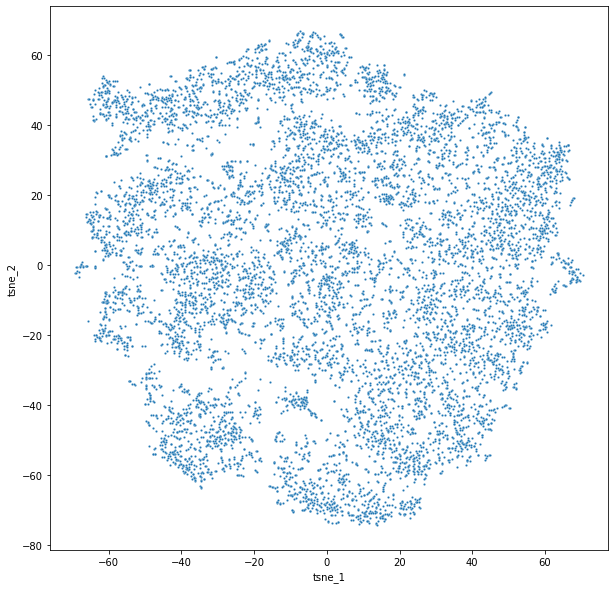

In [72]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1)
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x='tsne_1', 
    y='tsne_2', 
    data=tsne_result_df,
    s=5)

# lim = (tsne_result.min()-5, tsne_result.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
# plt.figure(figsize=(1000, 10000))
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)